#데이터 수집 및 전처리

reference:  
1. 모델 적합성 검사: https://mindscale.kr/course/basic-stat-python/14/
2. colab 한글 폰트 적용 https://jonsyou.tistory.com/22

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 글씨체 설정 코드입니다.
# 이 코드는 실행시키고 하면 바로 잘 적용되는듯?
# 사용자 정의 함수 사용할때도 잘 적용됨
!apt-get update -qq
!apt-get install fonts-nanum* -qq
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore') 

path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' # 나눔 고딕
font_name = fm.FontProperties(fname=path, size=10).get_name() # 기본 폰트 사이즈 : 10
plt.rc('font', family=font_name)
fm._rebuild()

Selecting previously unselected package fonts-nanum.
(Reading database ... 155632 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler 
import seaborn as sns
import re
from scipy.stats import probplot
import scipy
import requests 
import sys
import json
import datetime 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 대형마트 스크래핑

In [ ]:
code = pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/쓰레기배출량/행정_법정동_중심좌표.csv', encoding = 'utf-8')
seoul_code=code.loc[code["시도"]=="서울특별시"]# 법정동 중심 좌표를 기준으로 크롤링 예정, 해당 좌표 데이터 불러온 후 서울시 데이터만 사용
seoul_code=seoul_code[720:723] # 예시용 indexing, 실제로는 세션 초기화 되는 경우 대비책으로 쓰는 것 빼고는 굳이 안써도 됨.
seoul_code=seoul_code.reset_index()
display(seoul_code)

,index,코드,시도,시군구,읍면동,하위,위도,경도,코드종류
0,3842,1138010800,서울특별시,은평구,역촌동,NaN,37.604770,126.915663,B
1,3843,1138010900,서울특별시,은평구,신사동,NaN,37.595711,126.909195,B
2,3844,1138011000,서울특별시,은평구,증산동,NaN,37.584724,126.907223,B


In [ ]:
def json_request(url='', address="",encoding='utf-8', success=None, error=lambda e: print('%s : %s' % (e, datetime.now()), file=sys.stderr)):
  #Kakao API는 get 방식으로 데이터를 호출함, 
    headers = {'Authorization': 'KakaoAK {}'.format(APP_KEY)}
    #URL에 API 사용키를 넣는 것이 아닌, header에 넣는 방식으로 인증을 진행
    resp = requests.get(url,headers=headers)   
    #get형식으로 데이터를 호출한 후, 반환된 response를 변수에 저장
    return resp.text
    # 이후 response를 text(문자열)의 형태로 반환

In [ ]:
def reverse_code(raw_address):
    # 파라미터 최적화하여 url 생성
    url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + raw_address
    json_req = json_request(url=url,address=raw_address)
    #위에서 정의한 함수를 통해 API에서 데이터를 호출함.
    json_data = json.loads(json_req)
    #반환된 데이터를 json형식으로 변환
    json_doc = json_data.get('documents')[0]['address']
    #반환된 값 중 주소 데이터가 있는 부분을 parsing과 indexing을 통해 추출
    json_siname = json_doc['region_1depth_name']
    # 시 이름을 저장
    json_guname = json_doc['region_2depth_name']
    json_dongname = json_doc['region_3depth_h_name']

    return json_siname,json_guname,json_dongname

requests.get을 사용하면 해당 페이지가 반환하는 Response를 변수에 저장하게 됨.  
Kakao API가 json 형식으로 response를 반환하기 때문에, 반환된 값에서 데이터를 추출하기 위해서는 다음과 같은 방법으로 데이터를 뽑아내야 한다.

1. resp.text로 변수에 저장된 response를 텍스트 형태(문자열의 형태)로 변환하고, 이를 json.loads를 통해 json 형식으로 변환
이후 .get을 통해 데이터를 파싱하여 데이터를 추출.

2. resp.json을 통해 바로 변수에 저장된 response를 json형식으로 변환하고,
이를 indexing 한 다음 데이터를 pd.dataframe을 통해 데이터프레임으로 다시 변환한 후 데이터프레임에서 데이터를 추출

현재 사용자정의함수를 통해 데이터를 얻어낼 때에는 1번을 사용하였지만, 2번방식으로도 데이터를 얻어낼 수 있다.

물론 json형식도 어떤 계층적인 dictionary의 형태를 띄기 때문에 2가지 방법에는 차이가 없지만, 우리의 목표는 반복문을 통해 대형마트 목록과 행정동을 추출하려고 하기 때문에, 이 경우에는 1번 방식으로 데이터를 추출하는 것이 훨씬 효과적일 것으로 보인다.

In [ ]:
def get_address(raw_address):
    json_siname,json_guname,json_dongname = reverse_code(raw_address) 
    return json_siname,json_guname,json_dongname

이후 메커니즘이 이제 2개의 API를 혼합해서 사용하는 것인데  
API 1: 행정동/법정동 중심 기준으로 반경 10km 안 대형마트 목록과 좌표, 주소 수집  
API 2: 수집한 대형마트 목록이 법정동 기준이기 때문에, 행정동을 수집하기 위해서 도로명주소 기준으로 행정동을 구함.

In [ ]:
APP_KEY = '255d41e8b15b916fb2a184c907f04780' 

In [ ]:
## 서울 중심지 기준 크롤링: df에는 대형마트 이름, 대형마트 위경도, 대형마트 행정동이 들어갈 예정
big_market=pd.DataFrame(columns=["이름","위도","경도","구","행정동","주소"])

In [ ]:
for i in range(0,len(seoul_code)):
  print("seoul_code"+str(i)+"번째 출력입니다.")
  url = 'https://dapi.kakao.com/v2/local/search/category.json?category' 
  params = { 'x' : seoul_code["경도"][i], 'y' : seoul_code["위도"][i], 'radius' : 10000, 'category_group_code' : 'MT1','page':1,'size':15} 
  headers = {'Authorization': 'KakaoAK {}'.format(APP_KEY)}
  total = requests.get(url, params=params, headers=headers).json()['meta']['total_count'] 
  print(total)
  if(total%15==0):
    max_page=int(total/15)
  else:
    max_page=(total//15)+1
  for page_num in range(1,max_page+1):
    print(page_num)
    params = { 'x' : seoul_code["경도"][i], 'y' : seoul_code["위도"][i], 'radius' :  10000, 'category_group_code' : 'MT1','page':page_num,'size':15}
    places = requests.get(url, params=params, headers=headers).json()['documents']
    for j in range(15):
      try:
        target=places[j]
        #print(target)
        #이름
        temp_name=target["place_name"]
        #위도 경도
        temp_x=target["x"]
        temp_y=target["y"]
        #주소
        temp_address=target["road_address_name"]
        #행정구 서울특별시인지 확인 아니면 continue
        temp_si,temp_gu,temp_dong = get_address(temp_address)

        if(temp_si!="서울"):
          continue

        big_market=big_market.append({"이름":temp_name,"위도":temp_x,"경도":temp_y,"구":temp_gu,"행정동":temp_dong,"주소":temp_address} , ignore_index=True)
      except:
        pass
display(big_market)

seoul_code0번째 출력입니다.
170
1
2
3
4
5
6
7
8
9
10
11
12
seoul_code1번째 출력입니다.
183
1
2
3
4
5
6
7
8
9
10
11
12
13
seoul_code2번째 출력입니다.
199
1
2
3
4
5
6
7
8
9
10
11
12
13
14


,이름,위도,경도,구,행정동,주소
0,이마트 은평점,126.920178530965,37.6002746471855,은평구,응암1동,서울 은평구 은평로 111
1,서서울농협하나로마트 신사점,126.910461680358,37.6009055767837,은평구,신사1동,서울 은평구 갈현로 34
2,홈플러스익스프레스 구산점,126.91647908698266,37.61128578526835,은평구,구산동,서울 은평구 서오릉로 145
3,롯데슈퍼 역촌점,126.922437333119,37.6060749257025,은평구,역촌동,서울 은평구 진흥로 103
4,홈플러스익스프레스 신사점,126.910337275613,37.5988836595233,은평구,신사1동,서울 은평구 갈현로 10
...,...,...,...,...,...,...
490,서서울농협하나로마트 연서점,126.926326743391,37.6217365980371,은평구,불광2동,서울 은평구 연서로 291
491,GS더프레시 신촌숲아이파크점,126.93329980645268,37.5507569308655,마포구,신수동,서울 마포구 광성로 17
492,이마트 가양점,126.86190996899813,37.55814987281834,강서구,가양3동,서울 강서구 양천로 559
493,서서울농협하나로마트 서강점,126.93206303042781,37.54687202123837,마포구,서강동,서울 마포구 창전로 45


In [ ]:
mart1=pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/대형마트/서울 대형마트_utf8_선민.csv', encoding = 'utf-8')
mart2=pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/대형마트/서울 대형마트_utf8_시언 360-539.csv', encoding = 'utf-8')
mart3=pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/대형마트/서울 대형마트_utf8_이준_0-62번째.csv', encoding = 'utf-8')
mart4=pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/대형마트/서울 대형마트_utf8_이준_63-129번째.csv', encoding = 'utf-8')
mart5=pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/대형마트/서울 대형마트_utf8_이준_63-179번째.csv', encoding = 'utf-8')
mart6=pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/대형마트/서울 대형마트_utf8_현우.csv', encoding = 'utf-8')
mart7=pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/대형마트/서울 대형마트_utf8_sig_영호_180-269.csv', encoding = 'utf-8')
mart8=pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/대형마트/서울 대형마트_utf8_sig_영호_270-359.csv', encoding = 'utf-8')

# concat, reset_index, drop_duplicate 이름
mart=pd.concat([mart1,mart2,mart3,mart4,mart5,mart6,mart7,mart8])
mart=mart.dropna(subset=["행정동"],axis=0)
mart.reset_index(inplace=True)
mart.drop_duplicates(["이름"],inplace=True)
display(mart)

,index,이름,위도,경도,구,행정동,주소
0,0,롯데마트 서울역점,126.970213,37.556009,중구,회현동,서울 중구 한강대로 405
1,1,홈플러스익스프레스 광화문점,126.974834,37.570595,종로구,사직동,서울 종로구 새문안로 91
2,2,하나로마트 서대문점,126.967515,37.565681,중구,소공동,서울 중구 통일로 120
3,3,GS더프레시 서울역센트럴자이점,126.965319,37.554184,중구,중림동,서울 중구 만리재로 175
4,4,노브랜드 동대문두타몰점,127.008685,37.568750,중구,광희동,서울 중구 장충단로 275
...,...,...,...,...,...,...,...
158662,28907,남서울농협하나로마트 우면점,127.015986,37.456872,서초구,양재1동,서울 서초구 양재대로2길 116-19
158668,28913,롯데슈퍼 서초국제점,127.017992,37.485046,서초구,서초1동,서울 서초구 효령로 304
158671,28916,홈플러스익스프레스 서초2점,127.015450,37.486876,서초구,서초1동,서울 서초구 서초중앙로 56
158672,28917,이마트에브리데이 서초센트럴점,127.011544,37.486979,서초구,서초3동,서울 서초구 반포대로18길 36


## 인구 데이터 - R로 전처리, 추후 정리 예정

##음식점, 단란주점, 유흥업소 전처리

###음식점, 단란주점, 유흥업소 위경도, 주소, 행정동 스크래핑

위의 행정동 추출 및 위경도 추출과 코드가 유사하기 때문에 스크래핑을 진행하고 전처리 하는 부분을 주석처리

In [ ]:
#drink = pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/쓰레기배출량/서울특별시 단란주점영업 인허가 정보.csv', encoding = 'utf-8')
#general = pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/쓰레기배출량/서울특별시 일반음식점 인허가 정보.csv', encoding = 'utf-8')
#play = pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/쓰레기배출량/서울특별시 유흥주점영업 인허가 정보.csv', encoding = 'utf-8')

In [ ]:
# #해당 데이터에서 폐업한 가게들을 indexing을 통해 제외
# general=general.loc[general["영업상태명"]!="폐업"]
# play=play.loc[play["영업상태명"]!="폐업"]
# drink=drink.loc[drink["영업상태명"]!="폐업"]

In [ ]:
# #general_drink: 술 파는 음식점
# #general_food: 술 안파는 음식점
# list1=["통닭(치킨)", "호프/통닭", "회집", "횟집", "간이주점", "감성주점", "식육(숯불구이)", "정종/대포집/소주방"]
# #카테고리에서 술 위주로 판매하는 집을 직접 선정하여 구분해줌.
# general_drink=general[general['업태구분명'].isin(list1)]
# general_food=general[~general['업태구분명'].isin(list1)]
# general_drink=general_drink.reset_index()
# general_food=general_food.reset_index()

In [ ]:
# #정의한 함수는 대형마트 스크래핑과 동일함.
# #URL = 'https://dapi.kakao.com/v2/local/search/address.json'
# def json_request(url='', address="",encoding='utf-8', success=None, error=lambda e: print('%s : %s' % (e, datetime.now()), file=sys.stderr)):
#     headers = {'Authorization': 'KakaoAK {}'.format(APP_KEY)}
#     resp = requests.get(url,headers=headers)   
#     return resp.text
# def reverse_code(raw_address):
#     # 파라미터 최적화하여 url 생성
#     url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + raw_address
#     json_req = json_request(url=url,address=raw_address)
#     json_data = json.loads(json_req)
#     json_doc = json_data.get('documents')[0]['address']
#     json_guname = json_doc['region_2depth_name']
#     json_dongname = json_doc['region_3depth_h_name']
#     json_x=json_doc['x']
#     json_y=json_doc['y']
#     return json_guname,json_dongname,json_x,json_y
# def get_address(raw_address):
#     json_guname,json_dongname,json_x,json_y = reverse_code(raw_address) 
#     return json_guname,json_dongname,json_x,json_y

In [ ]:
###################################general_drink###############################################
# ##1. 주소 통일
# import re
# regex = r'(\w+[원,산,남,울,북,천,주,기,시,도]\s*)?' \
#         r'(\w+[구,시,군]\s*)?(\w+[구,시]\s*)?' \
#         r'(\w+[면,읍]\s*)' \
#         r'?(\w+\d*\w*[동,리,로,길]\s*)' \
#         r'?(\w*\d+-?\d*)?'

# for i in range(0,len(general_drink["지번주소"])):
#   print(i)
#   try: 
#     x = re.search(regex, general_drink["지번주소"][i])
#     print(x.group())
#     general_drink["지번주소"][i]=x.group()
#   except: # 공백값
#     general_drink["지번주소"][i]=None
# general_drink=general_drink[~general_drink["지번주소"].isnull()]

# ##2. 실행코드. 원 데이터프레임에서 행정동 추출하고 싶은 열 적어넣으면 됩니다.
# for i in range(0,len(general_drink["지번주소"])): 
#   try:
#     print(i)
#     raw_address = general_drink.iloc[i]['지번주소']
#     print(raw_address)
#     gu,dong,x,y = get_address(raw_address)
#     #x,y=
#     general_drink.loc[i, ['행정동']] = dong 
#     general_drink.loc[i, ['구']] = gu
#     general_drink.loc[i, ['경도']] = x
#     general_drink.loc[i, ['위도']] = y
#   except:
#     pass
#   if i%100 == 0:
#       print('{} 번째 경위도 좌표계에 대한 정보 불러오는 중...'.format(i))

In [ ]:
###################################general_food###############################################
# ##1. 주소 통일
# import re
# regex = r'(\w+[원,산,남,울,북,천,주,기,시,도]\s*)?' \
#         r'(\w+[구,시,군]\s*)?(\w+[구,시]\s*)?' \
#         r'(\w+[면,읍]\s*)' \
#         r'?(\w+\d*\w*[동,리,로,길]\s*)' \
#         r'?(\w*\d+-?\d*)?'

# for i in range(0,len(general_food["지번주소"])):
#   print(i)
#   try: 
#     x = re.search(regex, general_food["지번주소"][i])
#     print(x.group())
#     general_food["지번주소"][i]=x.group()
#   except: # 공백값
#     general_food["지번주소"][i]=None
# general_food=general_food[~general_food["지번주소"].isnull()]

# ##2. 실행코드. 원 데이터프레임에서 행정동 추출하고 싶은 열 적어넣으면 됩니다.
# for i in range(0,len(general_food["지번주소"])): 
#   try:
#     raw_address = general_food.iloc[i]['지번주소']
#     print(raw_address)
#     gu,dong,x,y = get_address(raw_address)
#     #x,y=
#     general_food.loc[i, ['행정동']] = dong 
#     general_food.loc[i, ['구']] = gu
#     general_food.loc[i, ['경도']] = x
#     general_food.loc[i, ['위도']] = y
#   except:
#     pass
#   if i%100 == 0:
#       print('{} 번째 경위도 좌표계에 대한 정보 불러오는 중...'.format(i))

In [ ]:
###################################play###############################################
# ##1. 주소 통일
# import re
# regex = r'(\w+[원,산,남,울,북,천,주,기,시,도]\s*)?' \
#         r'(\w+[구,시,군]\s*)?(\w+[구,시]\s*)?' \
#         r'(\w+[면,읍]\s*)' \
#         r'?(\w+\d*\w*[동,리,로,길]\s*)' \
#         r'?(\w*\d+-?\d*)?'

# for i in range(0,len(play["지번주소"])):
#   print(i)
#   try: 
#     x = re.search(regex, play["지번주소"][i])
#     print(x.group())
#     play["지번주소"][i]=x.group()
#   except: # 공백값
#     play["지번주소"][i]=None
# play=play[~play["지번주소"].isnull()]

# ##2. 실행코드. 원 데이터프레임에서 행정동 추출하고 싶은 열 적어넣으면 됩니다.
# for i in range(0,len(play["지번주소"])): 
#   try:
#     raw_address =play.iloc[i]['지번주소']
#     print(raw_address)
#     gu,dong,x,y = get_address(raw_address)
#     play.loc[i, ['행정동']] = dong 
#     play.loc[i, ['구']] = gu
#     play.loc[i, ['경도']] = x
#     play.loc[i, ['위도']] = y
#   except:
#     pass
#   if i%100 == 0:
#       print('{} 번째 경위도 좌표계에 대한 정보 불러오는 중...'.format(i))

In [ ]:
###################################drink###############################################
# ##1. 주소 통일
# import re
# regex = r'(\w+[원,산,남,울,북,천,주,기,시,도]\s*)?' \
#         r'(\w+[구,시,군]\s*)?(\w+[구,시]\s*)?' \
#         r'(\w+[면,읍]\s*)' \
#         r'?(\w+\d*\w*[동,리,로,길]\s*)' \
#         r'?(\w*\d+-?\d*)?'

# for i in range(0,len(drink["지번주소"])):
#   print(i)
#   try: 
#     x = re.search(regex, drink["지번주소"][i])
#     print(x.group())
#     drink["지번주소"][i]=x.group()
#   except: # 공백값
#     drink["지번주소"][i]=None
# drink=drink[~drink["지번주소"].isnull()]

# ##2. 실행코드. 원 데이터프레임에서 행정동 추출하고 싶은 열 적어넣으면 됩니다.
# for i in range(0,len(drink["지번주소"])): 
#   try:
#     raw_address = drink.iloc[i]['지번주소']
#     print(raw_address)
#     gu,dong,x,y = get_address(raw_address)
#     drink.loc[i, ['행정동']] = dong 
#     drink.loc[i, ['구']] = gu
#     drink.loc[i, ['경도']] = x
#     drink.loc[i, ['위도']] = y
#   except:
#     pass
#   if i%100 == 0:
#       print('{} 번째 경위도 좌표계에 대한 정보 불러오는 중...'.format(i))

In [ ]:
# ## 주점, 유흥업소, 일반음식점 nan(NA) 값 없애기
# drink=drink[~drink["지번주소"].isnull()]
# play=play[~play["지번주소"].isnull()]
# general_food=general_food[~general_food["지번주소"].isnull()]
# general_drink=general_drink[~general_drink["지번주소"].isnull()]

###음식점, 단란주점, 유흥업소 데이터 셋 정리

이후 쓰레기 배출량 예측에 사용할 음식점 수와 주점 수를 생성해줌.

In [ ]:
general_food=pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/음식점&주점/일반음식점_음식_final.csv',  encoding = 'utf-8')
general_drink=pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/음식점&주점/일반음식점_주점_final.csv',  encoding = 'utf-8')
play=pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/음식점&주점/유흥주점_final.csv', encoding = 'utf-8')
drink=pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/음식점&주점/단란주점_final.csv',  encoding = 'utf-8')
# 주점: general_food, play, drink
general_drink_dong = general_drink.groupby(['행정동','구'])['관리번호'].count()
drink_dong = drink.groupby(['행정동','구'])['관리번호'].count()
play_dong = play.groupby(['행정동','구'])['관리번호'].count()

merge_1=pd.merge(general_drink_dong,drink_dong,on=["행정동","구"],how="outer")
drink_total=pd.merge(merge_1,play_dong,on=["행정동","구"],how="outer")
drink_total.fillna(0,inplace=True)
drink_total["주점 수"]=drink_total["관리번호_x"]+drink_total["관리번호_y"]+drink_total["관리번호"]
drink_total=drink_total.drop(["관리번호_x","관리번호_y","관리번호"],axis=1)
drink_total=drink_total.reset_index()

# 일반음식점 수:
food_total = general_food.groupby(['행정동','구'])['관리번호'].count()
food_total=food_total.reset_index()
food_total.rename(columns={'관리번호':'음식점 수'},inplace=True)

display(food_total)
display(drink_total)

,행정동,구,음식점 수
0,가락1동,송파구,3
1,가락2동,송파구,6
2,가락본동,송파구,13
3,가리봉동,구로구,103
4,가산동,금천구,610
...,...,...,...
409,효창동,용산구,28
410,후암동,용산구,127
411,휘경1동,동대문구,101
412,휘경2동,동대문구,68


,행정동,구,주점 수
0,가락1동,송파구,9.0
1,가락2동,송파구,25.0
2,가락본동,송파구,79.0
3,가리봉동,구로구,68.0
4,가산동,금천구,147.0
...,...,...,...
414,효창동,용산구,9.0
415,후암동,용산구,15.0
416,휘경1동,동대문구,35.0
417,휘경2동,동대문구,19.0


## 구별 쓰레기 배출량 및 재활용률 전처리 - R로 전처리, 추후 정리 예정

## 환경인식지수 수집 및 전처리, 생성

In [ ]:
def anova(fomular, df, check_model_adequency=False):
  model = ols(fomular, df).fit()
  anova_lm(model)
  var=re.split('[~+]',fomular)
  for i, variable in enumerate(var):
    var[i]=re.sub('[C()]','',variable)
  
  fitted = model.predict(df)
  residual = df[var[0]] - fitted

  display(anova_lm(model)) # 아노바 결과 출력
  # 아노바 확인용 변수 플롯 생성 -> 상호작용있을 때 플롯은 아직 못그림, 좀 더 plot 그리는 거 생각해보기!
  for i in range(1,len(var)):
    plt.figure(figsize=(10,10))
    try:
      sns.boxplot(x=var[i],y=var[0],data=df)
      plt.show()

    except:
       pass

  if check_model_adequency==True:
    print('\n\nResidual Plot')
    plt.figure(figsize=(10,10))

    sr = scipy.stats.zscore(residual)
    sns.regplot(fitted, residual, lowess = True, line_kws = {'color':'red'})
    plt.show()

    print('\n\nNormal Q-Q Plot')
    plt.figure(figsize=(10,10))
    probplot(residual, plot=plt)
    plt.show()
    print('\n\nP-value of Shapiro-Wilks test : {}'.format(round(scipy.stats.shapiro(residual)[1],6)))
    # subplot으로 만들 수도 있지만, 혹시 생길 수 있는 문제를 배제하기 위해서 그래프를 일일히 생성함

  

###긍부정버즈 데이터 전처리

In [ ]:
annual_pn_buzz = pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/환경인식지수/2020_2021긍부정버즈.csv',
                             encoding = 'utf-8') #2020년 7월~ 2021년 6월 환경소셜 긍부정 버즈 데이터
annual_loc_buzz = pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/환경인식지수/2020_2021지역버즈.csv',
                             encoding = 'utf-8') #2020년 7월~ 2021년 6월 환경소셜 지역별 버즈 데이터
annual_loc_buzz['index']=list(range(0,len(annual_loc_buzz)))#merge할때 복사되는 행을 찾아내기 위해서 기준 데이터프레임인 지역별 버즈에 고유 번호를 매겨놓음
annual_buzz=pd.merge(annual_loc_buzz, annual_pn_buzz, how="left", on=['DATE_DTT','CHNNL_NM']) #left_join으로 데이터 프레임 결합
annual_buzz=annual_buzz.drop_duplicates('index')#고유 번호를 바탕으로 중복되는 행을 제거
annual_buzz=annual_buzz.drop(['DOMN_NM_y','CTGRY_NM_y','index'],axis=1)# 중복되는 열과 중복을 찾아내기 위해 만들었던 index를 제거해줌
annual_buzz.columns=['연월일','도메인명','카테고리명','SNS채널명','시도명','시군구명','주간시도언급량','긍정언급량','부정언급량','중립언급량','총언급량'] #영문으로 된 열 이름 수정
annual_buzz_all=annual_buzz[annual_buzz['SNS채널명']=='All']
annual_buzz_all['연월일'] = pd.to_datetime(annual_buzz_all['연월일'], errors='coerce')
annual_buzz_all['month'] = annual_buzz_all['연월일'].dt.month
month_buzz_total=annual_buzz_all.groupby(['시군구명','month']).sum().reset_index()
month_buzz_total['긍부정비율']=month_buzz_total['긍정언급량']/(month_buzz_total['긍정언급량']+month_buzz_total['부정언급량'])
new_data={'시군구명':'중랑구','month':1,'주간시도언급량':0, '긍정언급량':0,'부정언급량':0,
          '중립언급량':0,'총언급량':0,'긍부정비율':month_buzz_total['긍부정비율'].mean()}#중랑구의 1월 데이터가 존재하지 않아 직접 추가해줌,이때 긍부정 비율만 mean imputation 진행
month_buzz_total=month_buzz_total.append(new_data,ignore_index=True) #중랑구 데이터를 데이터프레임에 추가
month_buzz_total=month_buzz_total.sort_values(['시군구명','month']) #구명과 월을 기준으로 데이터 프레임 정렬
display(month_buzz_total)

,시군구명,month,주간시도언급량,긍정언급량,부정언급량,중립언급량,총언급량,긍부정비율
0,강남구,1,18,1989,1162,92081,95232,0.631228
1,강남구,2,22,2286,1211,103883,107380,0.653703
2,강남구,3,18,2101,1173,93325,96599,0.641723
3,강남구,4,7,1647,934,75230,77811,0.638125
4,강남구,5,18,1836,1055,86478,89369,0.635074
...,...,...,...,...,...,...,...,...
294,중랑구,8,12,9957,5735,402563,418255,0.634527
295,중랑구,9,20,8761,4991,347305,361057,0.637071
296,중랑구,10,7,8391,4552,327087,340030,0.648304
297,중랑구,11,27,14041,7594,534458,556093,0.648995


,df,sum_sq,mean_sq,F,PR(>F)
C(시군구명),24.0,0.000814,0.000034,1.029590,4.282894e-01
C(month),11.0,0.020839,0.001894,57.498171,1.272732e-63
Residual,264.0,0.008698,0.000033,NaN,NaN


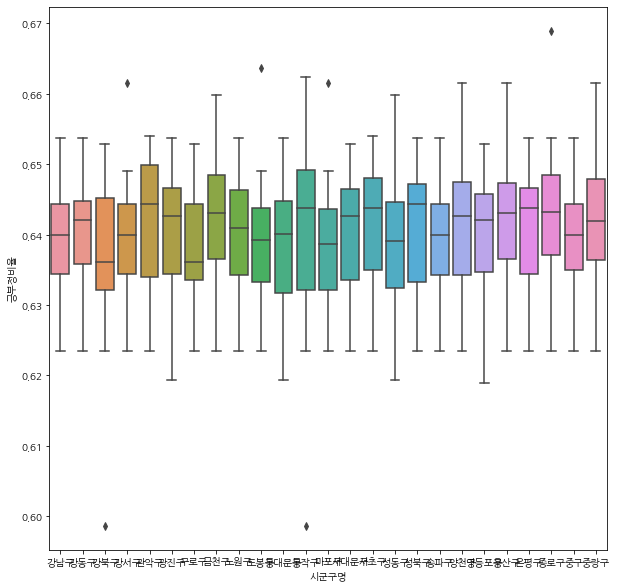

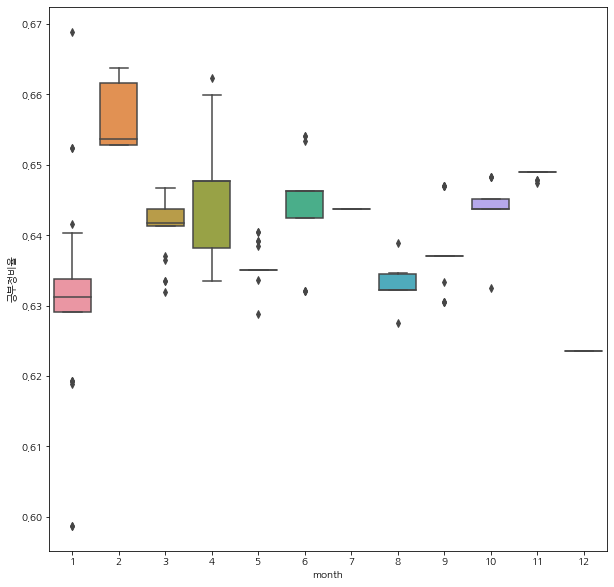

In [ ]:
anova('긍부정비율~C(시군구명)+C(month)',month_buzz_total)

RCBD를 통한 ANOVA 결과, 자치구별 긍부정비율의 차이는 나타나지 않지만, 월별 차이는 나타나는것을 확인 가능함.  
1. 이를 해소하기 위해서 월별 데이터를 연간 자치구별 데이터로 합치는 과정에서 가중평균으로 계산!  
2. 자치구별 긍부정비율의 차이가 통계적으로 유의미하지 않기 때문에, 자치구 별 긍부정 비율의 평균 차이는 나지 않으며, 따라서 기댓값적으로 자치구에 대해서 언급이 많이 될 수록 긍정적으로 언급된다고 판단, 월간 시도언급량을 바탕으로 환경인식지수에 쓰일 지표를 만들자!

In [ ]:
#month의 영향을 반영하기 위해서 총 언급 횟수를 활용한 해당기간 가중평균을 사용
annual_buzz_total_w=month_buzz_total.groupby('시군구명')
weighted_avg_func = lambda g:np.average(g['주간시도언급량'], weights=g['긍부정비율'])
annual_buzz_total_w=pd.DataFrame(annual_buzz_total_w.apply(weighted_avg_func))
annual_buzz_total_w.columns=['월간시도언급량_가중평균']
annual_buzz_total_w['월간시도언급량_평균']=month_buzz_total.groupby('시군구명').mean()['주간시도언급량']
annual_buzz_total_w['월간시도언급량_차이']=annual_buzz_total_w['월간시도언급량_가중평균']-annual_buzz_total_w['월간시도언급량_평균']
annual_buzz_total_w=annual_buzz_total_w.reset_index()
display(annual_buzz_total_w)

,시군구명,월간시도언급량_가중평균,월간시도언급량_평균,월간시도언급량_차이
0,강남구,33.099593,33.000000,0.099593
1,강동구,35.679070,35.666667,0.012403
2,강북구,11.527956,11.416667,0.111289
3,강서구,49.877990,49.916667,-0.038677
4,관악구,11.323044,11.333333,-0.010289
5,광진구,20.034817,20.000000,0.034817
6,구로구,10.209675,10.166667,0.043008
7,금천구,9.077973,9.083333,-0.005360
8,노원구,32.842323,32.833333,0.008990
9,도봉구,11.015465,11.000000,0.015465


### 에코마일리지 데이터 전처리

In [ ]:
annual_eco_private = pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/환경인식지수/2020_2021개인에코마일리지.csv', encoding = 'utf-8')
annual_eco_private['탄소감축량']=424*annual_eco_private['감축량(전기)']+332*annual_eco_private['감축량(수도)']+2240*(annual_eco_private['감축량(가스)']+annual_eco_private['감축량(지역난방)'])
#탄소감축량 공식을 활용하여 파생변수 생성
annual_eco_private['탄소배출량']=424*annual_eco_private['현재사용량(전기)']+332*annual_eco_private['현재사용량(수도)']+2240*(annual_eco_private['현재사용량(가스)']+annual_eco_private['현재사용량(지역난방)'])
#이를 현재 사용량에 적용하여 탄소배출량 파생변수 생성
annual_eco_private['탄소감축량']=annual_eco_private['탄소감축량']/1000 #kgCO2로 환산
for i in ['전기','가스','수도','지역난방']:
  annual_eco_private=annual_eco_private.drop([
                                              '전년사용량({})'.format(i),
                                              '전전년사용량({})'.format(i)
                                              ], axis=1)
annual_eco_private['current_use']=annual_eco_private['현재사용량(전기)']+annual_eco_private['현재사용량(수도)']+annual_eco_private['현재사용량(가스)']+annual_eco_private['현재사용량(지역난방)']
#단위에 상관없이 사용한 양의 총합을 현재사용량으로 정의하여 파생변수 생성

,df,sum_sq,mean_sq,F,PR(>F)
C(구청코드),24.0,1.115547e+05,4648.113549,0.915194,0.581358
C(월),11.0,2.526016e+05,22963.783401,4.521471,0.000003
Residual,264.0,1.340811e+06,5078.830714,NaN,NaN


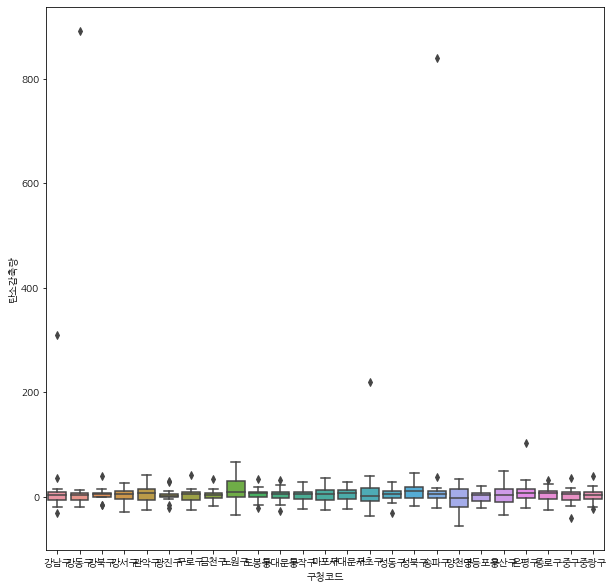

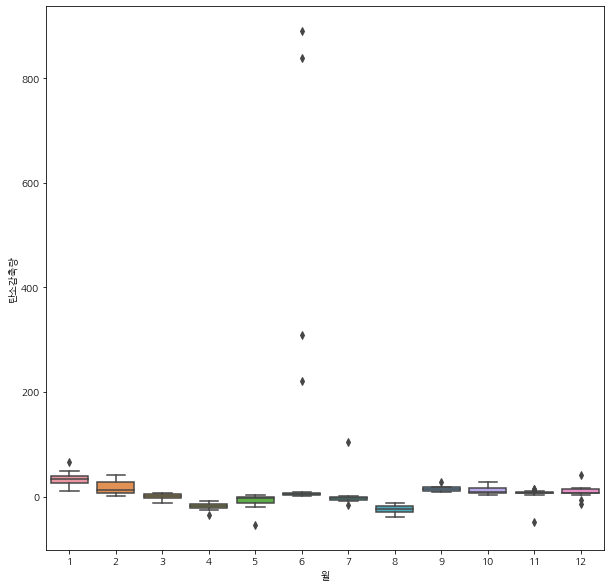



Residual Plot


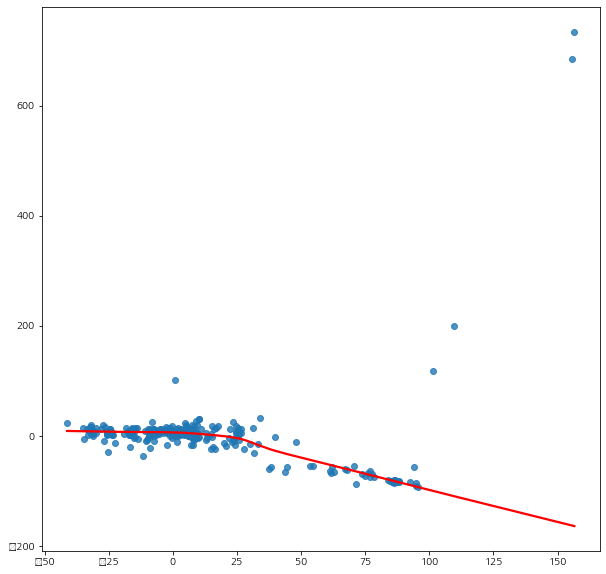



Normal Q-Q Plot


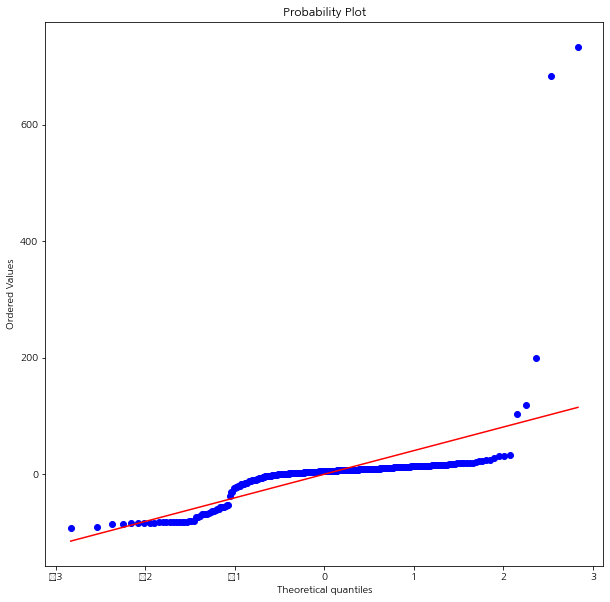



P-value of Shapiro-Wilks test : 0.0


In [ ]:
anova('탄소감축량~C(구청코드)+C(월)',annual_eco_private,True)

유의미한 차이가 나타날 것으로 예상되던 탄소감축량이 차이나지 않아  
모델적합성을 확인해본 결과 이상치로 인해 값들이 강하게 영향을 받고 있음을 확인 할 수 있었음  
-> 탄소 감축량 대신 탄소 배출량으로 다시 ANOVA를 실시함

,df,sum_sq,mean_sq,F,PR(>F)
C(구청코드),24.0,3.534469e+11,1.472695e+10,1.952616,5.990445e-03
C(월),11.0,1.453113e+12,1.321012e+11,17.515019,6.060939e-26
Residual,264.0,1.991131e+12,7.542164e+09,NaN,NaN


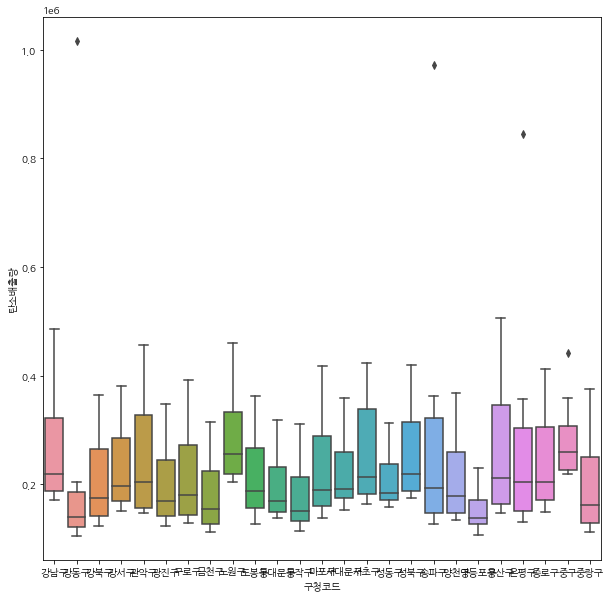

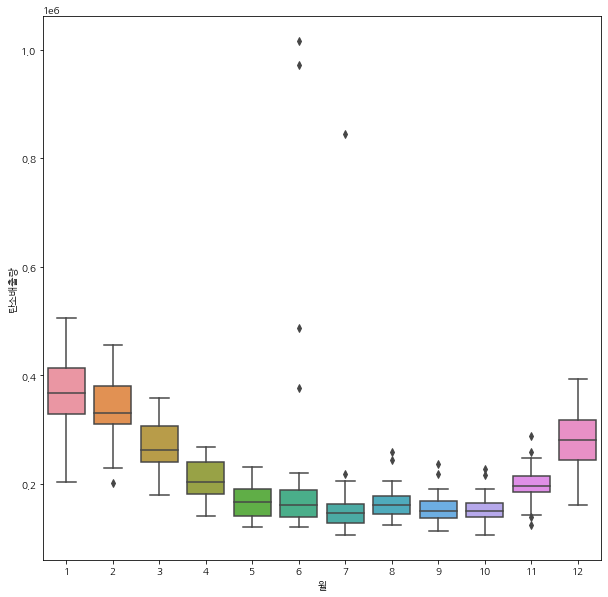

In [ ]:
anova('탄소배출량~C(구청코드)+C(월)',annual_eco_private)

탄소 배출량으로 ANOVA를 다시 진행하였을 때, 유의한 결과를 얻을 수 있었고,  
주간 버즈 데이터를 전처리할 때와 마찬가지로 현재 사용량을 기준으로 가중평균을 매겨 자치구별 데이터로 변환

In [ ]:
annual_eco_private_month=annual_eco_private.groupby('구청코드')
weighted_avg_func1 = lambda g:np.average(g['탄소배출량'], weights=g['current_use'])
annual_eco_private_month_w=pd.DataFrame(annual_eco_private_month.apply(weighted_avg_func1))
annual_eco_private_month_w.columns=['월간탄소배출량_가중평균']
annual_eco_private_month_w['월간탄소배출량_평균']=annual_eco_private.groupby('구청코드').mean()['탄소배출량']
annual_eco_private_month_w=annual_eco_private_month_w.reset_index()
display(annual_eco_private_month_w)

,구청코드,월간탄소배출량_가중평균,월간탄소배출량_평균
0,강남구,270159.157129,260018.008543
1,강동구,311295.615860,218960.665101
2,강북구,214130.145681,205200.805915
3,강서구,240238.566457,232627.514816
4,관악구,270333.165122,252564.305027
5,광진구,200502.392464,194965.042650
6,구로구,225470.710469,213583.909531
7,금천구,187433.202201,179438.879598
8,노원구,296657.371517,289111.526447
9,도봉구,222265.768553,214525.705221


### 자치구별 쓰레기 배출량 전처리

자치구별 재활용률을 환경인식지수에 사용

In [ ]:
gu_recycle = pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/1차 전처리/쓰레기배출량/행정동 별 쓰레기 배출량.csv', encoding = 'cp949',)
gu_recycle=gu_recycle.drop(['음식물','재활용','합계','혼합배출','Unnamed: 0'],axis=1)
display(gu_recycle)

,시군구,재활용rate
0,강남구,0.293
1,송파구,0.432
2,서초구,0.278
3,강서구,0.365
4,동대문구,0.521
5,노원구,0.338
6,영등포구,0.277
7,관악구,0.426
8,양천구,0.374
9,강동구,0.371


### 환경인식지수 생성

수집한 월간 탄소배출량 가중평균, 월간시도언급량 가중평균, 구별 재활용률을 하나의 데이터프레임으로 묶어줌.

In [ ]:
annual_summarise=pd.merge(annual_eco_private_month_w,annual_buzz_total_w, how="inner", left_on='구청코드', right_on='시군구명')
annual_summarise=pd.merge(annual_summarise ,gu_recycle, how="inner", left_on='구청코드', right_on='시군구')
annual_summarise=annual_summarise.drop(['월간탄소배출량_평균','시군구명','월간시도언급량_평균','월간시도언급량_차이','시군구'],axis=1)
annual_summarise.columns=['시군구명','월간탄소배출량_가중평균',	'월간시도언급량_가중평균','구별_재활용률']
annual_summarise_data=annual_summarise.set_index('시군구명')
display(annual_summarise_data)

,월간탄소배출량_가중평균,월간시도언급량_가중평균,구별_재활용률
시군구명,,,
강남구,270159.157129,33.099593,0.293
강동구,311295.615860,35.679070,0.371
강북구,214130.145681,11.527956,0.231
강서구,240238.566457,49.877990,0.365
관악구,270333.165122,11.323044,0.426
광진구,200502.392464,20.034817,0.410
구로구,225470.710469,10.209675,0.265
금천구,187433.202201,9.077973,0.353
노원구,296657.371517,32.842323,0.338


In [ ]:
scaler1 = StandardScaler()   
scaler1_result = scaler1.fit_transform(annual_summarise_data)
scaler2 = MinMaxScaler()
scaler2_result = scaler2.fit_transform(annual_summarise_data)
annual_summarise[['표준화탄소배출량','표준화시도언급량','표준화재활용률']]=scaler1_result
annual_summarise[['MinMax표준화탄소배출량','MinMax표준화시도언급량','MinMax표준화재활용률']]=scaler2_result
display(annual_summarise)

,시군구명,월간탄소배출량_가중평균,월간시도언급량_가중평균,구별_재활용률,표준화탄소배출량,표준화시도언급량,표준화재활용률,MinMax표준화탄소배출량,MinMax표준화시도언급량,MinMax표준화재활용률
0,강남구,270159.157129,33.099593,0.293,0.591064,1.419525,-0.922416,0.614535,0.595709,0.213793
1,강동구,311295.615860,35.679070,0.371,1.513747,1.655785,0.221802,0.838101,0.657864,0.482759
2,강북구,214130.145681,11.527956,0.231,-0.665657,-0.556274,-1.831923,0.310033,0.075920,0.000000
3,강서구,240238.566457,49.877990,0.365,-0.080050,2.956299,0.133786,0.451925,1.000000,0.462069
4,관악구,270333.165122,11.323044,0.426,0.594967,-0.575042,1.028623,0.615481,0.070983,0.672414
5,광진구,200502.392464,20.034817,0.410,-0.971325,0.222890,0.793912,0.235970,0.280901,0.617241
6,구로구,225470.710469,10.209675,0.265,-0.411290,-0.677019,-1.333161,0.371666,0.044155,0.117241
7,금천구,187433.202201,9.077973,0.353,-1.264464,-0.780674,-0.042248,0.164942,0.016885,0.420690
8,노원구,296657.371517,32.842323,0.338,1.185414,1.395961,-0.262290,0.758546,0.589510,0.368966
9,도봉구,222265.768553,11.015465,0.431,-0.483176,-0.603214,1.101970,0.354248,0.063571,0.689655


해당 변수들에 대해서 Standard Scaling과 Min-Max Scaling을 진행하였고, 해당 결과들을 비교해보았을 때, 어떠한 클러스터링의 변수로서 사용하기에는 Standard Scaling을 진행한 것들이, 어떠한 지수를 생성하기에는 Min-Max Scaling을 진행한 것이 더 좋다고 판단하였고, Min-Max scaling을 진행한 값을 바탕으로 환경인식지수를 생성해주었음.

In [ ]:
minmax_annual_summarise=annual_summarise[['시군구명','MinMax표준화탄소배출량',	'MinMax표준화시도언급량','MinMax표준화재활용률']]
minmax_annual_summarise['1-MinMax표준화탄소배출량']=round(1-minmax_annual_summarise['MinMax표준화탄소배출량'],6)
minmax_annual_summarise['환경인식지수']=(minmax_annual_summarise['1-MinMax표준화탄소배출량']+minmax_annual_summarise['MinMax표준화시도언급량']
                                   +minmax_annual_summarise['MinMax표준화재활용률'])/3
eco_aware_coef=minmax_annual_summarise[['시군구명','환경인식지수']]
display(minmax_annual_summarise)

,시군구명,MinMax표준화탄소배출량,MinMax표준화시도언급량,MinMax표준화재활용률,1-MinMax표준화탄소배출량,환경인식지수
0,강남구,0.614535,0.595709,0.213793,0.385465,0.398322
1,강동구,0.838101,0.657864,0.482759,0.161899,0.434174
2,강북구,0.310033,0.075920,0.000000,0.689967,0.255296
3,강서구,0.451925,1.000000,0.462069,0.548075,0.670048
4,관악구,0.615481,0.070983,0.672414,0.384519,0.375972
5,광진구,0.235970,0.280901,0.617241,0.764030,0.554057
6,구로구,0.371666,0.044155,0.117241,0.628334,0.263243
7,금천구,0.164942,0.016885,0.420690,0.835058,0.424211
8,노원구,0.758546,0.589510,0.368966,0.241454,0.399976
9,도봉구,0.354248,0.063571,0.689655,0.645752,0.466326
